<a href="https://colab.research.google.com/github/strongylocentrotus/Python_BI_2022/blob/fifth_homework_pandas/data/upd_hw_5_pandas_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

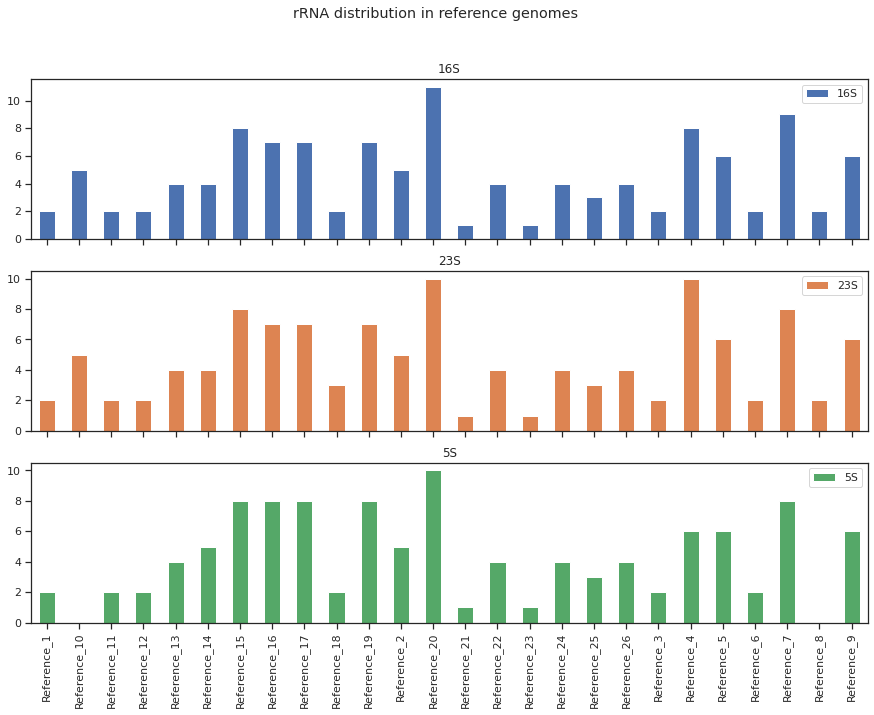

In [ ]:
import pandas as pd


def read_gff(annotation_file: str):
    col_names = ['chromosome', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    annotation_df = pd.read_csv(annotation_file, sep='\t', comment='#', names=col_names)

    return annotation_df


def read_bed6(alignment_file: str):
    col_names = ['chromosome', 'start', 'end', 'name', 'score', 'strand']
    alignment_df = pd.read_csv(alignment_file, sep='\t', comment='#', names=col_names)

    return alignment_df


def check_intersection(start_x, end_x, start_y, end_y): # checks if a contig completely intersects with some rRNA gene
    if start_y <= start_x and end_y >= end_x:
        return 'YES'
    else:
        return 'NOPE'


if __name__ == '__main__':
    rrna_df = read_gff('rrna_annotation.gff')
    lines_to_replace = ['Name=16S.*$', 'Name=23S.*$$', 'Name=5S.*$']
    rrna_df['attributes'] = rrna_df['attributes'].replace(lines_to_replace, ['16S', '23S', '5S'], regex=True)

    rrna_count = rrna_df.groupby('chromosome')['attributes'].value_counts() # counts rRNA in each chromosome
    sum_df = rrna_count.to_frame(name='quantity').reset_index(level=['chromosome', 'attributes']) # creates a data frame
    
    sum_df = sum_df.pivot(index='chromosome', columns='attributes', values='quantity')  # reshapes the data frame for a nice barplot
    
    rRNA_barplot = sum_df.plot.bar(figsize=(15, 10), xlabel='',
                                   title='rRNA distribution in reference genomes',
                                   subplots=True)
  
    align_df = read_bed6('alignment.bed')

    ann_align_df = rrna_df.merge(align_df, on='chromosome') # merges two data frames

    ann_align_df['result'] = ann_align_df.apply(lambda row: check_intersection(row['start_x'], row['end_x'], 
                                                                           row['start_y'], row['end_y']), axis=1)

    complete_rRNA_df = ann_align_df.loc[ann_align_df['result'] == 'YES'].drop('result', axis=1) # creates a data frame with complete rRNAs sequences


                    
    


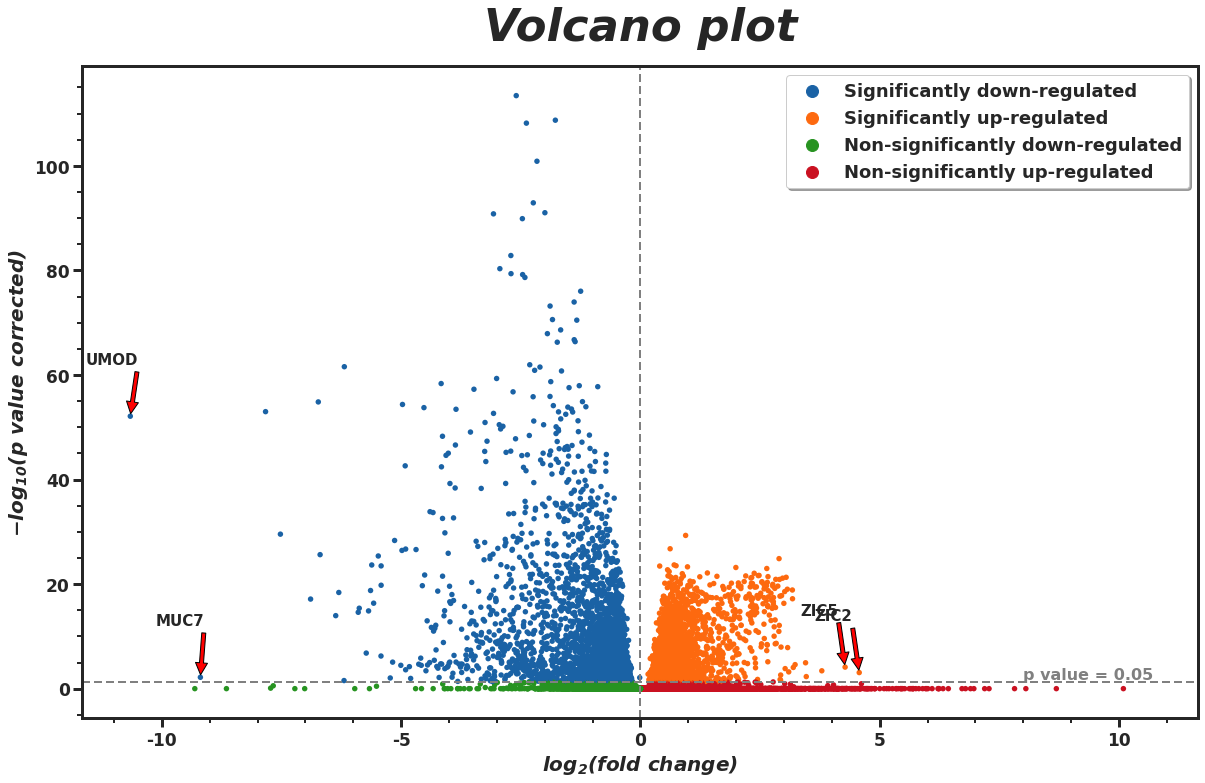

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import heapq
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc, rcParams
import matplotlib.font_manager as font_manager


def regulation_state(data_frame) -> str: # defines samples regulation
    logfc, pval = data_frame
    if logfc < 0 and pval < 0.05:
        return 'Significantly down-regulated'
    if logfc < 0 and pval > 0.05:
        return 'Non-significantly down-regulated'
    if logfc > 0 and pval < 0.05:
        return 'Significantly up-regulated'
    return 'Non-significantly up-regulated'


def get_top_samples(data_frame):    # extract data for top significantly regulated samples
    up_reg_samples = data_frame.loc[(data_frame['regulation'] == 'Significantly up-regulated')]
    down_reg_samples = data_frame.loc[(data_frame['regulation'] == 'Significantly down-regulated')]
    regulation = heapq.nlargest(2, up_reg_samples.logFC) + [-x for x in heapq.nlargest(2, abs(down_reg_samples.logFC))]
    sample_names = []
    p_value = []
    for value in regulation:
        sample_names.append(data_frame['Sample'][data_frame['logFC'] == value].iloc[0])
        p_value.append(data_frame['log_pval'][data_frame['logFC'] == value].iloc[0])
        
    return regulation, sample_names, p_value


if __name__ == '__main__':
    diffexpr_data = pd.read_csv('diffexpr_data.tsv.gz', sep='\t')

    diffexpr_data['regulation'] = diffexpr_data[['logFC', 'pval_corr']].apply(regulation_state, axis=1)

    # setting colors for each section
    colors = {'Significantly down-regulated': '#1A62A5', 'Significantly up-regulated': '#FD690F',
               'Non-significantly down-regulated': '#279321', 'Non-significantly up-regulated': '#CA1121'}

    # setting fonts
    rcParams["mathtext.fontset"] = 'custom'
    rcParams['mathtext.bf'] = 'DejaVu Sans:italic:bold'
    font_for_legend = font_manager.FontProperties(family='DejaVu Sans', weight='bold', size=18)

    # setting figure size and enabling ticks
    sns.set(rc={'figure.figsize': (20, 12), "xtick.bottom": True, "ytick.left": True})
    sns.set_style('ticks')

    # building scatterplot
    scat_vol = sns.scatterplot(data=diffexpr_data, x='logFC', y='log_pval', hue='regulation',
                               hue_order=['Significantly down-regulated', 'Significantly up-regulated',
                                            'Non-significantly down-regulated', 'Non-significantly up-regulated'],
                               palette=colors, s=30, linewidth=0)
    # setting x-limits
    min_max = abs(min(diffexpr_data['logFC']) - 1), abs(max(diffexpr_data['logFC']) + 1)
    x_limits = [-max(min_max), max(min_max)]

    # setting axis and spines parameters
    scat_vol.set_xlim(x_limits)
    for x in ['top', 'left', 'bottom', 'right']:
        scat_vol.spines[x].set_linewidth(3)

    # setting title and labels
    scat_vol.set_title('Volcano plot', y=1.03, fontfamily='DejaVu Sans',
                       weight='bold', style='italic', fontsize=45)
    scat_vol.set_xlabel(r'$\mathbf{log_2}$(fold change)', fontfamily='DejaVu Sans',
                        weight='bold', style='italic', fontsize=25)
    scat_vol.set_ylabel(r'$\mathbf{-log_{10}}$(p value corrected)', fontfamily='DejaVu Sans',
                        weight='bold', style='italic', fontsize=25)

    # setting ticks
    scat_vol.xaxis.set_minor_locator(AutoMinorLocator())
    scat_vol.yaxis.set_minor_locator(AutoMinorLocator())
    scat_vol.tick_params(which='major', length=9, width=3)
    scat_vol.tick_params(which='minor', length=5, width=2)
    y_labels = ['0', '0', '20', '40', '60', '80', '100']
    scat_vol.set_yticklabels(labels=y_labels, fontfamily='DejaVu Sans',
                             weight='bold', fontsize=17)
    x_labels = ['0', '-10', '-5', '0', '5', '10']
    scat_vol.set_xticklabels(labels=x_labels, fontfamily='DejaVu Sans',
                             weight='bold', fontsize=17)

    # setting legend
    legend = scat_vol.legend(markerscale=2.3, shadow=True, prop=font_for_legend)

    # adding 4 sections
    pv_label = 'p value = 0.05'
    scat_vol.axvline(0, color='grey', dashes=(4, 2), lw=2)
    scat_vol.axhline(-np.log10(0.05), color='grey', dashes=(4, 2), lw=2, label=pv_label)
    scat_vol.text(8, -np.log10(0.05) + 0.5, pv_label, fontfamily='DejaVu Sans',
                  weight='bold', fontsize=16, color='grey')

    # adding samples
    # extracting top 2 significantly regulated (up and down) samples
    logFC_values, sample_names, p_values = get_top_samples(diffexpr_data)
    for i, sample in enumerate(sample_names):
        scat_vol.annotate(sample, xy=(logFC_values[i], p_values[i]),
                          xytext=(logFC_values[i] - 0.94, p_values[i] + 10),
                          fontfamily='DejaVu Sans', fontsize=15, weight='bold',
                          arrowprops={'facecolor': 'red', 'ec': 'black', 'shrink': 0.05})


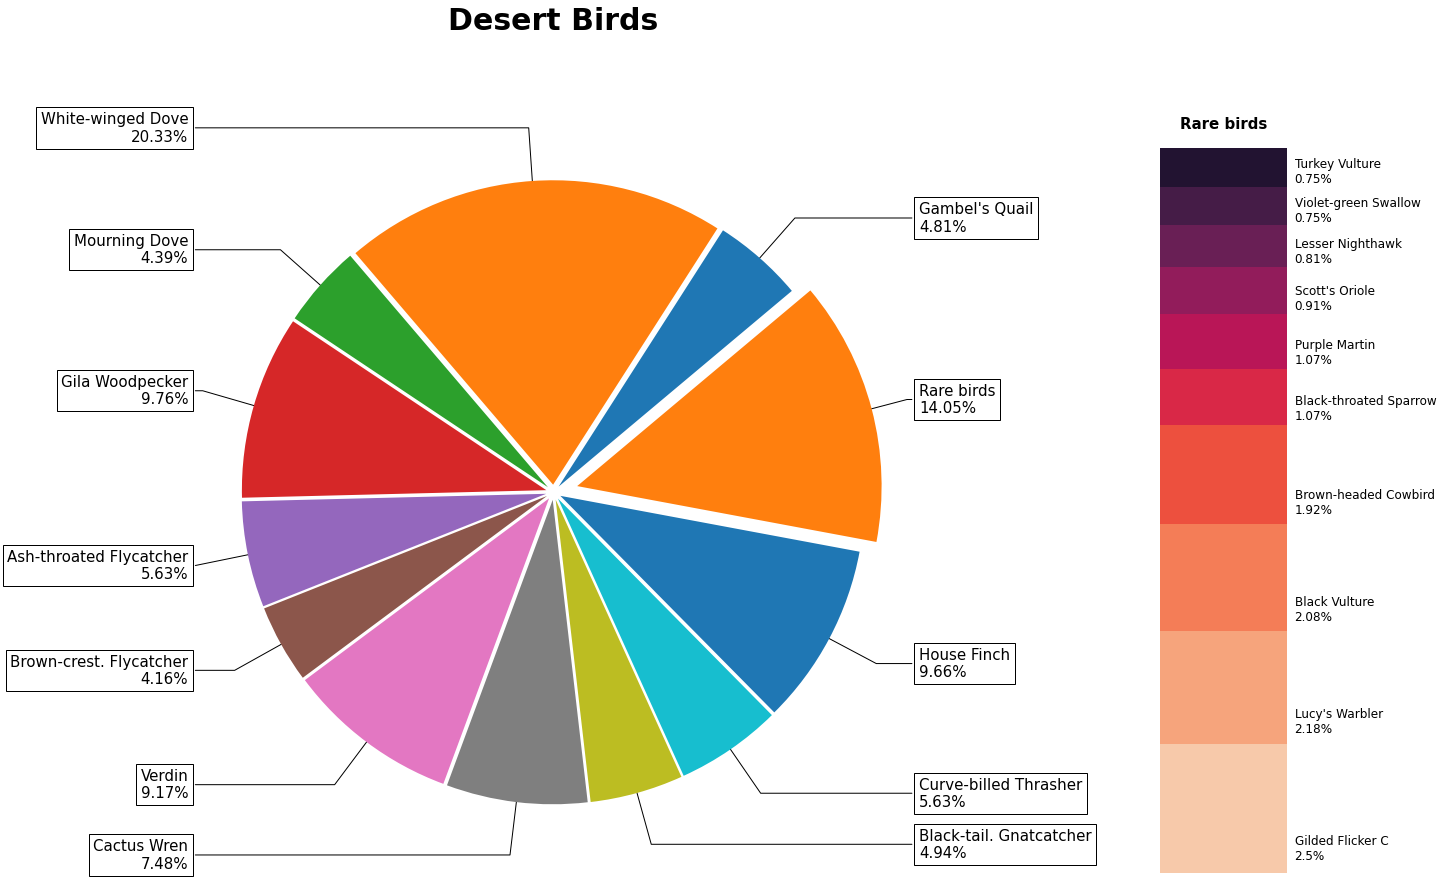

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def bird_type(percentage):
    if percentage <= 3:
        return 'Rare'
    else:
        return 'Common'


if __name__ == '__main__':
    birds = pd.read_csv('desert_birds.csv')

    sum_birds = sum(birds['Count'])
    birds = birds.assign(Percentage=lambda x: round((x['Count'] / sum_birds)*100, 2))
    birds['Type'] = birds.apply(lambda row: bird_type(row['Percentage']), axis=1)
    all_rares = sum(birds.loc[birds['Type'] == 'Rare']['Count'])

    species = list(birds.loc[birds['Type'] == 'Common']['Species']) + ['Rare birds']
    quantity = list(birds.loc[birds['Type'] == 'Common']['Count']) + [all_rares]
    perc = list(birds.loc[birds['Type'] == 'Common']['Percentage']) + [round(all_rares/sum_birds * 100, 2)]

    explode = (0.025, ) * (len(quantity) - 1) + (0.08, )
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 14), gridspec_kw={'width_ratios': [7, 1]})
    wedges, texts = ax1.pie(quantity, startangle=40, explode=explode)

    ax1.set_title('Desert Birds', y=1.1, fontfamily='sans', fontsize=30, weight='bold')

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
    arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=90", linewidth=1)

    kw = dict(xycoords='data', textcoords='data', arrowprops=arrowprops,
              bbox=bbox_props, zorder=0, va='center')

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        label = species[i] + '\n' + str(perc[i]) + '%'
        ax1.annotate(label, xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                     horizontalalignment=horizontalalignment,
                     fontsize=15, **kw)

    # bar chart parameters
    rare_species = birds.loc[birds['Type'] == 'Rare']['Species']
    rare_counts = birds.loc[birds['Type'] == 'Rare']['Count']
    rare_perc = birds.loc[birds['Type'] == 'Rare']['Percentage']
    rare_data = [*zip(rare_perc, rare_species, rare_counts)]
    rare_data.sort(key=lambda tup: tup[0])
    bottom = 1
    palette = sns.color_palette('rocket', n_colors=len(rare_species))

    for j, (perc, species, counts) in enumerate(rare_data):
        bottom -= counts
        bc = ax2.bar(0, height=counts, bottom=bottom, color=palette[j], label=species)
        plt.text(0.45, bottom + 0.1 * counts, f"{species}\n{perc}%", fontsize=12)

    ax2.set_title('Rare birds', fontsize=15, y=0.97, weight='bold')
    ax2.axis('off')
    plt.show()



